In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from PIL import Image

In [2]:
torch.__version__

'2.1.2'

In [3]:
import torchvision
torchvision.__version__

'0.16.2'

In [4]:
#normalize the input images with mean and standard deviation values commonly used on pre-trained models on ImageNet
normalize=transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])

In [5]:
#Define data transformations for training and validation datasets
data_transforms={'train':transforms.Compose([transforms.Resize((224,224)),
                                            transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            normalize]),
                'validation':transforms.Compose([transforms.Resize((224,224)),
                                                transforms.ToTensor(),
                                               normalize])
                }
# Data Loading and Augmentation:

# The RandomAffine transformation is a good choice for data augmentation. You can also consider adding more augmentation techniques like rotation and color jittering.
# Try experimenting with different data augmentation techniques to enhance the model's ability to generalize.

In [6]:
#/kaggle/input/alien-vs-predator-images/data
input_path='/kaggle/input/alien-vs-predator-images/data/'
train_path=input_path+'train'
validation_path=input_path+'validation'


In [7]:
#create datasets
image_datasets={'train':datasets.ImageFolder(input_path+'train',data_transforms['train']),
                'validation':datasets.ImageFolder(input_path+'validation',data_transforms['validation'])
}

In [8]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 694
     Root location: /kaggle/input/alien-vs-predator-images/data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomAffine(degrees=[0.0, 0.0], scale=(0.8, 1.2), shear=[-10.0, 10.0])
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 200
     Root location: /kaggle/input/alien-vs-predator-images/data/validation
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [9]:
import os
#List contentsof root directory
root_contents=os.listdir('/kaggle/input/alien-vs-predator-images/data/train')
print(root_contents)
#Explore datasets
for root,dirs,files in os.walk('/kaggle/input/alien-vs-predator-images/data/train'):
    print(f'Root:{root},Directories:{dirs},Files:{files}')

['predator', 'alien']
Root:/kaggle/input/alien-vs-predator-images/data/train,Directories:['predator', 'alien'],Files:[]
Root:/kaggle/input/alien-vs-predator-images/data/train/predator,Directories:[],Files:['208.jpg', '333.jpg', '45.jpg', '56.jpg', '89.jpg', '20.jpg', '275.jpg', '212.jpg', '239.jpg', '58.jpg', '150.jpg', '6.jpg', '109.jpg', '149.jpg', '187.jpg', '76.jpg', '71.jpg', '342.jpg', '272.jpg', '270.jpg', '182.jpg', '215.jpg', '185.jpg', '243.jpg', '153.jpg', '189.jpg', '143.jpg', '327.jpg', '253.jpg', '343.jpg', '115.jpg', '131.jpg', '5.jpg', '151.jpg', '8.jpg', '260.jpg', '202.jpg', '84.jpg', '237.jpg', '273.jpg', '286.jpg', '283.jpg', '85.jpg', '67.jpg', '265.jpg', '289.jpg', '118.jpg', '82.jpg', '295.jpg', '176.jpg', '279.jpg', '30.jpg', '97.jpg', '334.jpg', '106.jpg', '163.jpg', '113.jpg', '160.jpg', '38.jpg', '328.jpg', '211.jpg', '42.jpg', '291.jpg', '197.jpg', '33.jpg', '10.jpg', '234.jpg', '178.jpg', '54.jpg', '271.jpg', '251.jpg', '0.jpg', '130.jpg', '62.jpg', '278.jp

In [10]:
train_dataloader=DataLoader(image_datasets['train'],batch_size=32,shuffle=True,num_workers=0)
validation_dataloader=DataLoader(image_datasets['validation'],batch_size=32,shuffle=False,num_workers=0)


In [11]:
for x,y in validation_dataloader: #Image - Color image shape (batch_size,number of channel,length,width)
    print(x.shape)            #Image - Black and white image - number of channels is 1
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
import torchvision.models as models

# Load ResNet model with pre-trained weights
#resnet = models.resnet50(weights='imagenet')
model = models.resnet50(pretrained=True).to(device) 

    
for param in model.parameters():
    param.requires_grad = False   #making the pretrained model not to update thats y false
    
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)
).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s] 


In [14]:
from torch.optim import lr_scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)#Consider using a learning rate scheduler to adjust the learning rate during training. It can help converge faster and achieve better accuracy.


In [15]:
#steps in the GD : Batch of the input / Pass it to the model / Compute loss function / Update the weights

def train(dataloader,model,loss_fn,optimizer):
    model.train() #putting the model in the training mode
    for batch,(X,y) in enumerate(dataloader):
    #sending the data to the GPU
        X = X.to(device)
        y = y.to(device)

    #Compute predictions
    pred = model(X)

    #Compute loss
    loss = loss_fn(pred,y)

    #Backpropogation
    loss.backward() #Wnew = Wold - lr*dl/dw
    optimizer.step()
    scheduler.step()#ou would then update the learning rate in your training loop:
    optimizer.zero_grad()

    if batch % 100 == 0:
        print(f'Loss of the Model {loss.item()}')


In [16]:
def test(dataloader,model,loss_fn):
    model.eval() #putting the model in the training mode
    num_batched = len(dataloader)
    test_loss, correct = 0,0
    with torch.no_grad(): #We will not compute gradients for the test data
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)

      #Compute predictions
            pred = model(X)

      #Compute loss
            test_loss += loss_fn(pred,y).item()

      #Find how many correct predictions  .
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss = test_loss/num_batched
    correct = correct/(len(dataloader.dataset))

    print(f'Test Accuracy {100*correct}, Avg_loss : {test_loss}')

In [17]:
epochs = 5

for t in range(5):
    print(f'Epoch {t+1}')
    train(train_dataloader,model,loss_fn,optimizer)
    test(validation_dataloader,model,loss_fn)

Epoch 1
Test Accuracy 72.5, Avg_loss : 0.628103392464774
Epoch 2
Test Accuracy 75.5, Avg_loss : 0.5696423990385873
Epoch 3
Test Accuracy 71.0, Avg_loss : 0.5339567150388446
Epoch 4
Test Accuracy 72.5, Avg_loss : 0.4935522675514221
Epoch 5
Test Accuracy 73.0, Avg_loss : 0.47068149064268383


In [18]:
# Ensure that the paths to the validation images are correct
validation_img_paths = ["validation/alien/21.jpg",
                        "validation/alien/10.jpg",
                        "validation/predator/81.jpg"]


In [19]:
# Load images and apply transformations
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [20]:
# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[-0.1360,  0.0555],
        [ 0.2913, -0.4745],
        [-0.8649,  0.8765]], device='cuda:0')

In [21]:
# Calculate probabilities and convert to numpy array
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.45227695, 0.5477231 ],
       [0.68261933, 0.3173807 ],
       [0.14913985, 0.8508601 ]], dtype=float32)

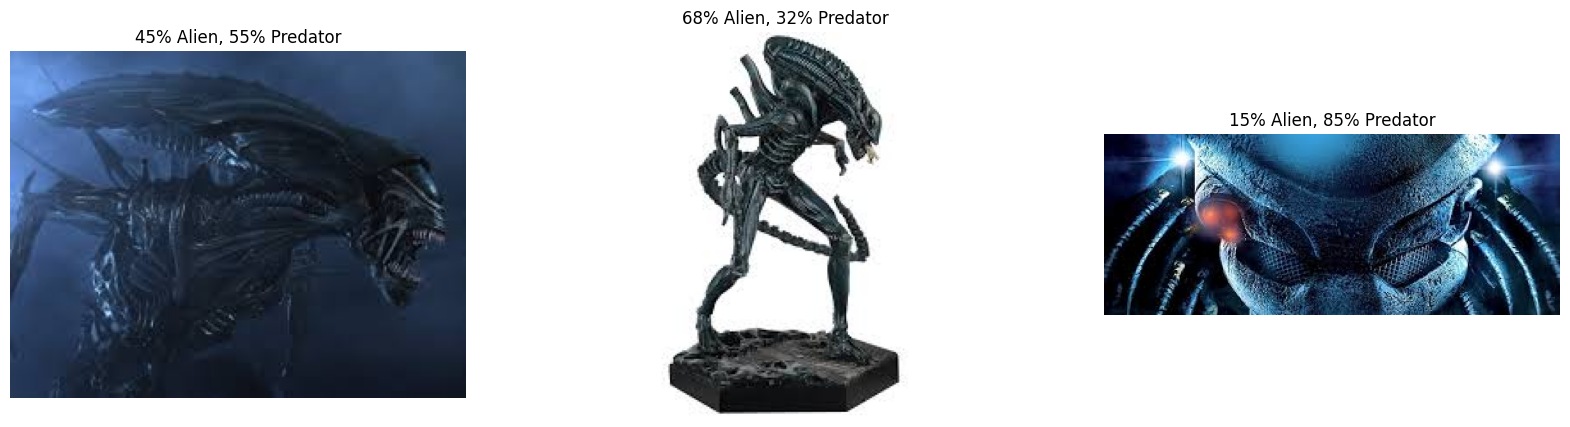

In [22]:
# Visualize results
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

plt.show()